In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Load datasets
train = pd.read_csv("HousePrice_train.csv")
test = pd.read_csv("HousePrice_test.csv")

# Save the test Id for final submission
test_ID = test['Id']


C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


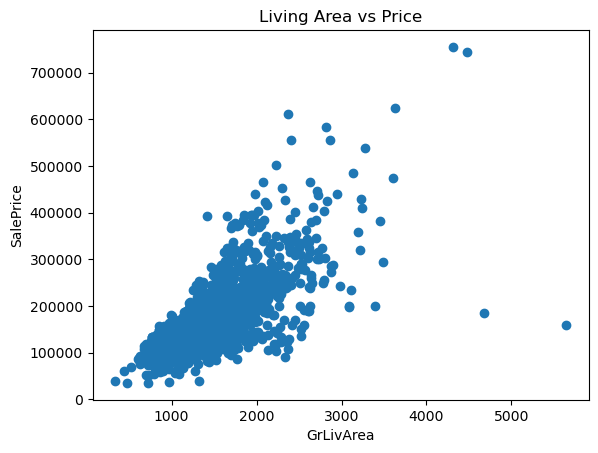

In [2]:
# Visualize to detect outliers in GrLivArea vs SalePrice
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("Living Area vs Price")
plt.show()

# Remove extreme outliers manually based on visualization
train = train[train['GrLivArea'] < 4500]


In [3]:
# Drop SalePrice from train and save separately
train_labels = train['SalePrice']
train_data = train.drop(['SalePrice'], axis=1)

# Combine train and test for uniform feature handling
combined = pd.concat([train_data, test], axis=0, sort=False)
print("Combined shape:", combined.shape)


Combined shape: (2917, 80)


In [4]:
# Count missing values
missing = combined.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing data:\n", missing.head(10))

# Impute values based on context (simplified for demonstration)
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    combined[col] = combined[col].fillna("None")

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    combined[col] = combined[col].fillna("None")

# Fill numeric columns with median
numeric_cols = combined.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    combined[col] = combined[col].fillna(combined[col].median())

# Fill categorical columns with mode
categorical_cols = combined.select_dtypes(include=[object]).columns
for col in categorical_cols:
    combined[col] = combined[col].fillna(combined[col].mode()[0])


Missing data:
 PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
dtype: int64


In [5]:
# One-hot encode categorical variables
combined = pd.get_dummies(combined)
print("Shape after encoding:", combined.shape)


Shape after encoding: (2917, 296)


In [6]:
# Re-split the combined data
X_train = combined.iloc[:train.shape[0], :]
X_test = combined.iloc[train.shape[0]:, :]

# Log-transform the target to reduce skew
y_train = np.log1p(train_labels)


In [7]:
# Ridge regression with scaling
ridge = make_pipeline(RobustScaler(), Ridge(alpha=10))

# Gradient Boosting
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=42)

# Evaluate with cross-validation
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                     scoring="neg_mean_squared_error", cv=5))
    return rmse

print("Ridge RMSE:", rmse_cv(ridge).mean())
print("GBM RMSE:", rmse_cv(gboost).mean())


Ridge RMSE: 0.11490579259810238
GBM RMSE: 0.11602905765981988


In [8]:
# Fit model on full data
gboost.fit(X_train, y_train)

# Predict on test
preds = gboost.predict(X_test)

# Reverse log transform
final_preds = np.expm1(preds)


In [12]:
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": final_preds
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved!")


Submission file saved!
